# IFT experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math
from statistics import mean, stdev
import pandas as pd

import qiskit
from qiskit import *

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

In [3]:
def generate_img(n):

    sky_image = np.zeros((n, n), dtype='complex64')
    mask = np.zeros((n, n), dtype='bool')
    stars = np.random.randint(1, 7) 
    radius = 1 

    for i in range(0, stars):
        index_i = np.random.randint(0, n-radius)
        index_j = np.random.randint(0, n-radius)
        for j in range(0, radius):
            for k in range(0, radius):
                sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
                mask[index_i+j][index_j+k] = True
            
    sky_image.real += np.random.randn(n,n)/100
    sky_image.imag += np.random.randn(n,n)/100
    
    visibilities = np.fft.fft2(sky_image).astype('complex64')
    
    return sky_image, visibilities

In [4]:
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) 

        if binary[i]=='1':
            qc.x(off_set+i) 
    
    off_set += len(binary)

    return off_set

In [5]:
def binary(img):
    
    number_of_pixels = img.shape[0]*img.shape[1]
    number_of_bits_real = 32
    number_of_bits_imag = 32
    number_of_bits = number_of_bits_real + number_of_bits_imag
    number_of_qbits = number_of_pixels*number_of_bits
    off_set = 0

    qc = QuantumCircuit(number_of_qbits)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
                binary_real = float_to_bin_real(img[i, j].real)
                binary_imag = float_to_bin_imag(img[i, j].imag)
                binary = binary_real+binary_imag
                off_set = binary_encode(qc, binary, off_set)
                
    qc.measure_all()
    backend = Aer.get_backend('aer_simulator') 
    job = backend.run(qc, shots=1, memory=True) 
    output = job.result().get_memory()[0]
    out = reverse(output)
    
    chunks_real = []
    chunks_imag = []
    for i in range(0, number_of_pixels):
        chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) 
        chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) 

    readout = []
    for i in range(0, len(chunks_real)):
        readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

    readout = np.array(readout).reshape(img.shape[0] , img.shape[1]).astype('complex64')
    readout = np.fft.ifft2(readout).astype('complex64') #IFT
    
    return readout

In [6]:
def MSE(img1, img2):
    diff_real = (img1.real - img2.real)
    diff_imag = (img1.imag - img2.imag)
    diff_sum = diff_real + diff_imag
    
    mse = (diff_sum**2).mean()
    
    return mse

In [7]:
img_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
basis_results = []
amplitude_results = []

for i in tqdm(range(0, len(img_sizes))):
    
    iterations = 100
    img_size = img_sizes[i]
    binary_MSE = []
    amplitude_MSE = []

    for j in range(0, iterations):

        initial, visibilities = generate_img(img_size) 

        # BINARY
        binary_readout = binary(visibilities)

        # AMPLITUDE
        n_n = img_size*img_size
        inp = visibilities.flatten()
        norm = qml.math.sum(qml.math.abs(inp) ** 2)
        number_of_qbits = math.ceil(math.log2(n_n))
        wires = range(number_of_qbits)
        amp_dev = qml.device('default.qubit', wires)
        @qml.qnode(amp_dev)
        def amp_encoding(data):
            qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
            return qml.state()
        readout = amp_encoding(inp).astype('complex64')
        readout.numpy()
        readout = readout*qml.math.sqrt(norm) 
        readout = readout[:n_n] 
        readout = np.array(readout).reshape(img_size , img_size)
        amplitude_readout = np.fft.ifft2(readout).astype('complex64')

        binary_mse = MSE(initial, binary_readout)
        amplitude_mse = MSE(initial, amplitude_readout)

        binary_MSE.append(binary_mse)
        amplitude_MSE.append(amplitude_mse)

    binary_mean = mean(binary_MSE)
    binary_std = np.std(binary_MSE)
    amplitude_mean = mean(amplitude_MSE)
    amplitude_std = np.std(amplitude_MSE)
    
    basis_results.append((binary_mean, binary_std))
    amplitude_results.append((amplitude_mean, amplitude_std))

print('Basis results: '+ '\033[1m' + str(basis_results) + '\033[0m')
print()
print('Amplitude results: '+ '\033[1m' + str(amplitude_results) + '\033[0m')

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:11<00:00, 47.99s/it]

Basis results: [(8.9930055e-13, 9.721684e-13), (7.944254e-13, 6.3711357e-13), (6.4478864e-13, 4.801983e-13), (5.327465e-13, 3.9964259e-13), (3.714758e-13, 2.735017e-13), (2.672521e-13, 1.8539974e-13), (2.1469316e-13, 1.4950161e-13), (1.601858e-13, 8.567118e-14), (1.3796065e-13, 8.0277846e-14)]

Amplitude results: [(5.8717198e-12, 1.2442825e-11), (6.8902076e-12, 1.0862507e-11), (3.1982797e-12, 3.7982846e-12), (3.6404824e-12, 5.5000557e-12), (2.7702465e-12, 3.9211533e-12), (1.9182112e-12, 2.8766768e-12), (8.7562184e-13, 1.247335e-12), (9.837513e-13, 1.3438514e-12), (1.2093607e-12, 1.6995167e-12)]


In [8]:
basis_tmp = []
for i in range(0, len(basis_results)):
    basis_tmp.append(basis_results[i][0])
basis_absolute_mean = mean(basis_tmp)

amplitude_tmp = []
for i in range(0, len(amplitude_results)):
    amplitude_tmp.append(amplitude_results[i][0])
amplitude_absolute_mean = mean(amplitude_tmp)

basis_tmp2 = []
for i in range(0, len(basis_results)):
    basis_tmp2.append(basis_results[i][1])
basis_absolute_std = mean(basis_tmp2)

amplitude_tmp2 = []
for i in range(0, len(amplitude_results)):
    amplitude_tmp2.append(amplitude_results[i][1])
amplitude_absolute_std = mean(amplitude_tmp2)

print('Basis absolute mean: '+ '\033[1m' + str(basis_absolute_mean) + '\033[0m')
print('Basis absolute std: '+ '\033[1m' + str(basis_absolute_std) + '\033[0m')
print()
print('Amplitude absolute mean: '+ '\033[1m' + str(amplitude_absolute_mean) + '\033[0m')
print('Amplitude absolute std: '+ '\033[1m' + str(amplitude_absolute_std) + '\033[0m')

Basis absolute mean: 4.4698094e-13
Basis absolute std: 3.6260833e-13

Amplitude absolute mean: 3.0397646e-12
Amplitude absolute std: 4.8546896e-12


In [9]:
df_mean = pd.DataFrame({'antennas':['2','3','4','5','6','7','8','9','10'],
                   'Binary':basis_tmp,
                    'Amplitude':amplitude_tmp})
df_mean = df_mean.set_index('antennas')
df_mean

,Binary,Amplitude
antennas,,
2,8.993005e-13,5.871720e-12
3,7.944254e-13,6.890208e-12
4,6.447886e-13,3.198280e-12
5,5.327465e-13,3.640482e-12
6,3.714758e-13,2.770246e-12
7,2.672521e-13,1.918211e-12
8,2.146932e-13,8.756218e-13
9,1.601858e-13,9.837513e-13
10,1.379606e-13,1.209361e-12


In [10]:
df_std = pd.DataFrame({'antennas':['2','3','4','5','6','7','8','9','10'],
                   'Binary':basis_tmp2,
                    'Amplitude':amplitude_tmp2})
df_std = df_std.set_index('antennas')
df_std

,Binary,Amplitude
antennas,,
2,9.721684e-13,1.244283e-11
3,6.371136e-13,1.086251e-11
4,4.801983e-13,3.798285e-12
5,3.996426e-13,5.500056e-12
6,2.735017e-13,3.921153e-12
7,1.853997e-13,2.876677e-12
8,1.495016e-13,1.247335e-12
9,8.567118e-14,1.343851e-12
10,8.027785e-14,1.699517e-12


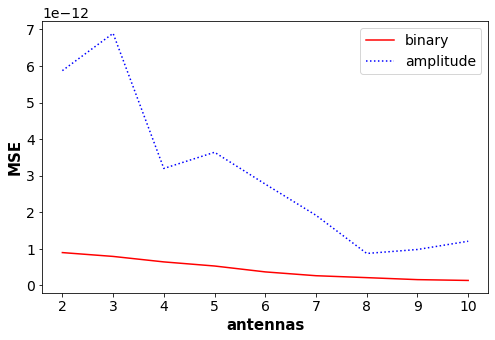

In [21]:
x = img_sizes
fig = plt.gcf()
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(x, basis_tmp, label = "binary", color='red')
plt.plot(x, amplitude_tmp, label = "amplitude", linestyle=":", color='blue')
plt.xlabel('antennas', fontsize=15, weight='bold')
plt.ylabel('MSE', fontsize=15, weight='bold')
plt.legend()
fig.set_size_inches(8, 5)
plt.savefig('plot1.jpg', dpi=100)
plt.show()

In [12]:
basis_qubits = [256,576,1024,1600,2304,3136,4096,5184,6400]
basis_qubits_mean = mean(basis_qubits)
amplitude_qubits = [2,4,4,5,6,6,6,7,7]
amplitude_qubits_mean = mean(amplitude_qubits)
print(basis_qubits_mean)
print()
print(amplitude_qubits_mean)

2730.6666666666665

5.222222222222222


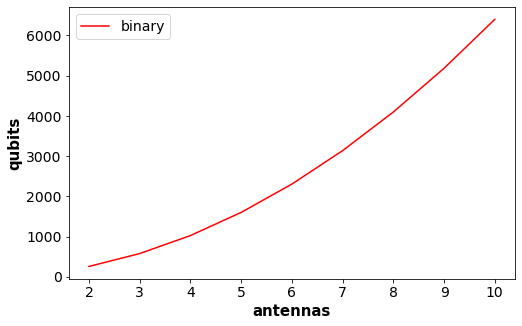

In [22]:
x = img_sizes
fig = plt.gcf()
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(x, basis_qubits, label = "binary", color='red')
#plt.plot(x, amplitude_tmp, label = "amplitude", linestyle=":", color='blue')
plt.xlabel('antennas', fontsize=15, weight='bold')
plt.ylabel('qubits', fontsize=15, weight='bold')
plt.legend()
fig.set_size_inches(8, 5)
plt.savefig('plot2.jpg', dpi=100)
plt.show()

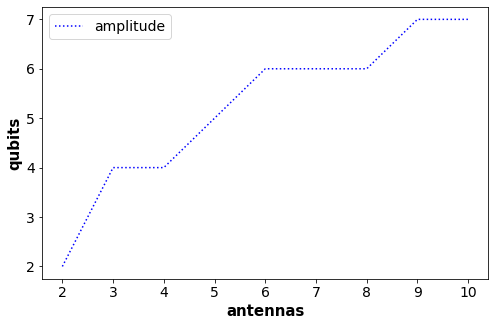

In [20]:
x = img_sizes
fig = plt.gcf()
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
#plt.plot(x, basis_qubits, label = "basis", color='red')
plt.plot(x, amplitude_qubits, label = "amplitude", linestyle=":", color='blue')
plt.xlabel('antennas', fontsize=15, weight='bold')
plt.ylabel('qubits', fontsize=15, weight='bold')
plt.legend()
fig.set_size_inches(8, 5)
plt.savefig('plot3.jpg', dpi=100)
plt.show()